<a href="https://colab.research.google.com/github/AcidCannon/CMPUT466-Mini-project/blob/master/task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchvision import datasets, transforms
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
config = {}
config['training_size'] = 60000
config['training_batch_size'] = 128
config['training_shuffle'] = True
config['device'] = 'gpu'
config['generator_learning_rate'] = 0.0002
config['generator_weight_decay'] = 0
config['discriminator_learning_rate'] = 0.0002
config['discriminator_weight_decay'] = 0
config['algorithm'] = 'Generative Adversarial Network'
config['number_of_epochs'] = 200
config['discriminator_real_loss_coe'] = 1.0
config['discriminator_fake_loss_coe'] = 1.0
config['tracking_progress'] = True
config['visualize'] = True
config['mode'] = 'demo' # 'fresh_start' 'load_and_train' 'test' 'demo'
# if mode is fresh_start, you will train the GAN from scratch, when finished, learning curve will show
# if mode is load_and_train, you will first load checkpoint and train, when finished, learning curve will show
# if mode is test, you will first randomly generate noise then generate fake mnist image, a comparison will show
# if mode is demo, you will first download latest checkpoint trained by me from my github repo, then:
#   first, you will load the checkpoint
#   second, learning curve will show
#   third, noise will be randomly generated and evolution of fake mnist will show(change per 10 epochs)

In [3]:
if config['mode'] == 'demo':
  # load last time trained model and data
  !wget 'https://raw.githubusercontent.com/AcidCannon/CMPUT466-Mini-project-data/master/task3_data.z01'
  !wget 'https://raw.githubusercontent.com/AcidCannon/CMPUT466-Mini-project-data/master/task3_data.z02'
  !wget 'https://raw.githubusercontent.com/AcidCannon/CMPUT466-Mini-project-data/master/task3_data.z03'
  !wget 'https://raw.githubusercontent.com/AcidCannon/CMPUT466-Mini-project-data/master/task3_data.z04'
  !wget 'https://raw.githubusercontent.com/AcidCannon/CMPUT466-Mini-project-data/master/task3_data.zip'
  !zip -F task3_data.zip --out task3.zip
  !unzip task3.zip
else:
  # mount google drive to save checkpoints
  from google.colab import drive
  drive.mount('/content/gdrive')

--2020-05-03 11:03:22--  https://raw.githubusercontent.com/AcidCannon/CMPUT466-Mini-project-data/master/task3_data.z01
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51380224 (49M) [application/octet-stream]
Saving to: ‘task3_data.z01’

task3_data.z01      100%[===================>]  49.00M   155MB/s    in 0.3s    

2020-05-03 11:03:22 (155 MB/s) - ‘task3_data.z01’ saved [51380224/51380224]

--2020-05-03 11:03:24--  https://raw.githubusercontent.com/AcidCannon/CMPUT466-Mini-project-data/master/task3_data.z02
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response..

In [0]:
def load_data(config):
  MNIST_training_set = datasets.MNIST(root='data', train=True, download=True, transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))
                  ]))
  
  MNIST_training_set = torch.utils.data.Subset(MNIST_training_set, range(0, config['training_size']))

  training_dataloader = torch.utils.data.DataLoader(dataset=MNIST_training_set, batch_size=config['training_batch_size'], shuffle=config['training_shuffle'])
  return training_dataloader

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(100, 256)
    self.fc2 = nn.Linear(256, 512)
    self.fc3 = nn.Linear(512, 1024)
    self.fc4 = nn.Linear(1024, 784)
  
  def forward(self, x):
    x = F.leaky_relu(self.fc1(x), 0.2, True)
    x = F.leaky_relu(self.fc2(x), 0.2, True)
    x = F.leaky_relu(self.fc3(x), 0.2, True)
    return torch.tanh(self.fc4(x))

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 1)
  
  def forward(self, x):
    # using dropout to prevent overfitting, p=0.5
    x = F.leaky_relu(self.fc1(x), 0.2, True)
    x = F.dropout(x)
    x = F.leaky_relu(self.fc2(x), 0.2, True)
    x = F.dropout(x)
    x = F.leaky_relu(self.fc3(x), 0.2, True)
    x = F.dropout(x)
    return torch.sigmoid(self.fc4(x))

In [0]:
def discriminator_train(config, data, discriminator_optimizer, discriminator, generator, loss_function):
  # set gradient to be zero
  discriminator_optimizer.zero_grad()
  
  real_data = (data.view(-1, 784)).to(config['device'])
  real_target = (torch.ones(data.shape[0], 1)).to(config['device'])

  # forward propagation for real
  output = discriminator(real_data)
  # compute loss for real
  discriminator_real_loss = loss_function(output, real_target)

  fake_data = generator(torch.randn(data.shape[0], 100).to(config['device']))
  fake_target = (torch.zeros(data.shape[0], 1)).to(config['device'])

  # forward propagation for fake
  output = discriminator(fake_data)
  # compute loss for fake
  discriminator_fake_loss = loss_function(output, fake_target)

  # compute total loss as a combination of real loss and fake loss
  discriminator_total_loss = config['discriminator_real_loss_coe']*discriminator_real_loss + config['discriminator_fake_loss_coe']*discriminator_fake_loss
  
  # backward propagation for total loss
  discriminator_total_loss.backward()
  
  # weight updation
  discriminator_optimizer.step()
  
  return discriminator_total_loss

In [0]:
def generator_train(config, data, generator_optimizer, discriminator, generator, loss_function):
  # set gradient to be zero
  generator_optimizer.zero_grad()

  # let generator generates fake image and see if discriminator can discriminate it
  # first forward propagate for generator
  fake_data = generator(torch.randn(data.shape[0], 100).to(config['device']))
  real_target = (torch.ones(data.shape[0], 1)).to(config['device'])

  # then forward propagate for discriminator
  output = discriminator(fake_data)

  # compute loss for generator
  generator_total_loss = loss_function(output, real_target)

  # backward propagation for total loss
  generator_total_loss.backward()

  # weight updation
  generator_optimizer.step()

  return generator_total_loss

In [0]:
def train(training_dataloader, config, device):
  loss_function = F.binary_cross_entropy
  '''
    I neither know why from line 10 to line 15 will trigger this warning, nor know how to solve it. :(
    However it will not influence program running, so I just ignore it. :)
    /pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors.
    This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor.
    You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
  '''
  if config['mode'] == 'load_and_train':
    discriminator = config['discriminator_loaded']
    generator = config['generator_loaded']
  elif config['mode'] == 'fresh_start':
    discriminator = Discriminator().to(device)
    generator = Generator().to(device)
  discriminator.train()
  generator.train()
  discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=config['discriminator_learning_rate'], weight_decay = config['discriminator_weight_decay'])
  generator_optimizer = torch.optim.Adam(generator.parameters(), lr=config['generator_learning_rate'], weight_decay=config['generator_weight_decay'])
  for epoch in range(1, config['number_of_epochs']+1):
    discriminator_loss = 0
    discriminator_count = 0
    generator_loss = 0
    generator_count = 0
    for idx, (data, target) in enumerate(training_dataloader):
      discriminator_loss += discriminator_train(config, data, discriminator_optimizer, discriminator, generator, loss_function)
      discriminator_count += 1
      generator_loss += generator_train(config, data, generator_optimizer, discriminator, generator, loss_function)
      generator_count += 1
    print("Epoch: {}.\tGenerator Avg.loss: {}.\tDiscriminator Avg.loss: {}.".format(epoch, generator_loss/generator_count, discriminator_loss/discriminator_count))
    if config['visualize']:
      with torch.no_grad():
        noise = torch.randn(10, 100).to(config['device'])
        generated = generator(noise)
        # prepare(reshape) noise to plot
        noise = (noise.reshape(-1, 10, 10)).cpu().numpy()
        # prepare(reshape) generated image to plot
        generated = (generated.reshape(-1, 28, 28)).cpu().numpy()
        # plot
        ax = []
        fig = plt.figure(figsize=(20,20))
        fig.subplots_adjust(top=0.4)
        fig.suptitle("Noise and Generated Images", fontsize=16, y=0.4)
        for image_set, row in [(noise, 2), (generated, 1)]:
          for i in range(1, 11):
            img = image_set[i-1, :, :]
            ax.append(fig.add_subplot(row, 10, i))
            plt.imshow(img, cmap='gray')
        for a in ax:
          a.axis('off')
        plt.show()
        del ax  
    if config['mode'] == 'fresh_start' or config['mode'] == 'load_and_train':
      torch.save(generator.state_dict(), '/content/gdrive/My Drive/checkpoints/g.ckpt.{}.pth'.format(epoch))
      torch.save(discriminator.state_dict(), '/content/gdrive/My Drive/checkpoints/d.ckpt.{}.pth'.format(epoch))
      print('Checkpoint saved.')
      if config['tracking_progress']:
        f = open('/content/gdrive/My Drive/checkpoints/gan_progress.csv', 'a+')
        f.write('{},{}\n'.format(generator_loss/generator_count, discriminator_loss/discriminator_count))
        f.close()

In [0]:
def plot_learning_curve(filepath):
  if config['mode'] == 'demo':
    config['number_of_epochs'] = 200
  dataframe = pd.read_csv(filepath, header=None)
  plt.figure(figsize=(10, 10))
  plt.title("Learning Curve", fontsize=14)
  plt.xlabel("Epoch", fontsize=12)
  plt.ylabel("Avg. loss", fontsize=12)
  plt.plot(np.array(range(1, config['number_of_epochs']+1)), dataframe.values[:, 0], label="Generator Avg. Loss")
  plt.plot(np.array(range(1, config['number_of_epochs']+1)), dataframe.values[:, 1], label='Discriminator Avg. Loss')
  plt.legend()
  plt.savefig('loss.jpg')

In [0]:
def run(config):
  print('Training set size: {}x{}.'.format(config['training_size'], '1x28x28'))
  print('Using algorithm: {}.'.format(config['algorithm']))
  print('Running in {} mode.'.format(config['mode']))

  if config['device'] != 'cpu' and torch.cuda.is_available():
    config['device'] = torch.device('cuda')
    print('Using GPU: {}.'.format(torch.cuda.get_device_name(0)))
  else:
    config['device'] = torch.device('cpu')
    print('Using CPU.')

  print("Running...")

  if config['mode'] == 'test':
    generator = Generator().to(config['device'])
    discriminator = Discriminator().to(config['device'])

    generator.load_state_dict(torch.load('/content/gdrive/My Drive/checkpoints/g.ckpt.pth'))
    discriminator.load_state_dict(torch.load('/content/gdrive/My Drive/checkpoints/d.ckpt.pth'))

    with torch.no_grad():
      noise = torch.randn(10, 100).to(config['device'])
      generated = generator(noise)

      # prepare(reshape) noise to plot
      noise = (noise.reshape(-1, 10, 10)).cpu().numpy()
      # prepare(reshape) generated image to plot
      generated = (generated.reshape(-1, 28, 28)).cpu().numpy()
      # plot
      ax = []
      fig = plt.figure(figsize=(20,20))
      fig.subplots_adjust(top=0.4)
      fig.suptitle("Noise and Generated Images", fontsize=16, y=0.4)
      for image_set, row in [(noise, 2), (generated, 1)]:
        for i in range(1, 11):
          img = image_set[i-1, :, :]
          ax.append(fig.add_subplot(row, 10, i))
          plt.imshow(img, cmap='gray')
      for a in ax:
        a.axis('off')
      plt.show()
      del ax   
  elif config['mode'] == 'fresh_start':  
    train(load_data(config), config, config['device'])
    plot_learning_curve('/content/gdrive/My Drive/checkpoints/gan_progress.csv')
  elif config['mode'] == 'load_and_train':
    generator = Generator().to(config['device'])
    discriminator = Discriminator().to(config['device'])

    generator.load_state_dict(torch.load('/content/gdrive/My Drive/checkpoints/g.ckpt.pth'))
    discriminator.load_state_dict(torch.load('/content/gdrive/My Drive/checkpoints/d.ckpt.pth'))

    config['generator_loaded'] = generator
    config['discriminator_loaded'] = discriminator

    train(load_data(config), config, config['device'])
    plot_learning_curve('/content/gdrive/My Drive/checkpoints/gan_progress.csv')
  elif config['mode'] == 'demo':
    plot_learning_curve('gan_progress.csv')
    with torch.no_grad():
      noise = torch.randn(10, 100)
      reshaped_noise = noise.numpy().reshape(-1, 10, 10)
      fig = plt.figure(figsize=(10, 10))
      ax = []
      fig.suptitle("Noise and Evolving Generated Images", fontsize=16, y=0.6)
      for i in range(1, 11):
        img = reshaped_noise[i-1, :, :]
        ax.append(fig.add_subplot(1, 10, i))
        plt.imshow(img, cmap='gray')
      for a in ax:
        a.axis('off')
      plt.show()
      del ax

    for epoch in range(10, config['number_of_epochs']+10, 10):

      generator = Generator().to(config['device'])
      discriminator = Discriminator().to(config['device'])

      generator.load_state_dict(torch.load('g.ckpt.{}.pth'.format(epoch)))
      discriminator.load_state_dict(torch.load('d.ckpt.{}.pth'.format(epoch)))

      with torch.no_grad():
        generated = generator(noise.to(config['device']))
        generated = (generated.reshape(-1, 28, 28)).cpu().numpy()
        ax = []
        fig = plt.figure(figsize=(10, 10))
        for i in range(1, 11):
          img = generated[i-1, :, :]
          ax.append(fig.add_subplot(1, 10, i))
          plt.imshow(img, cmap='gray')
        for a in ax:
          a.axis('off')
        plt.show()
        del ax

Training set size: 60000x1x28x28.
Using algorithm: Generative Adversarial Network.
Running in demo mode.
Using GPU: Tesla K80.
Running...


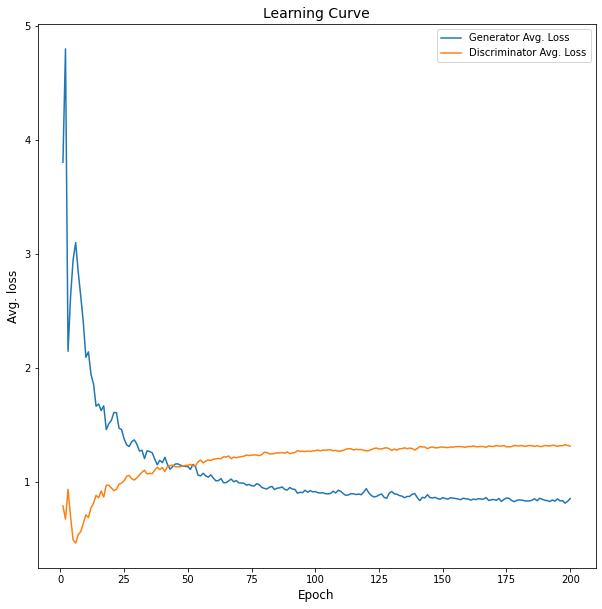

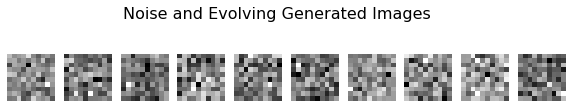

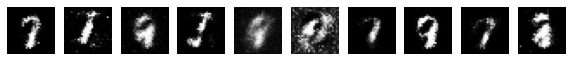

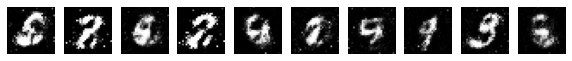

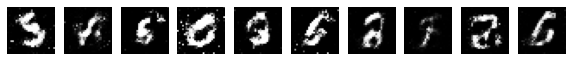

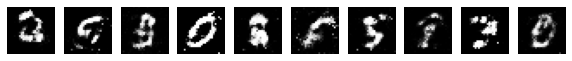

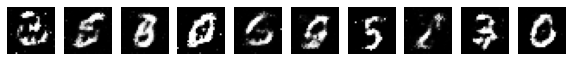

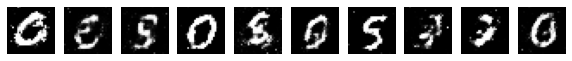

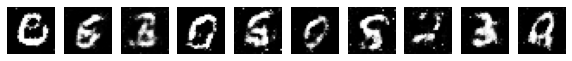

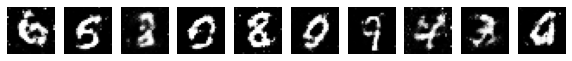

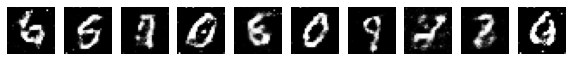

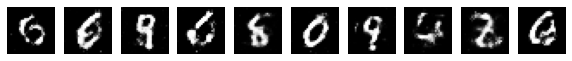

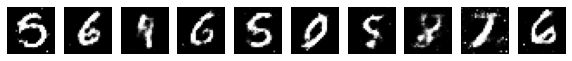

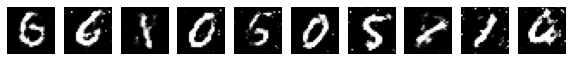

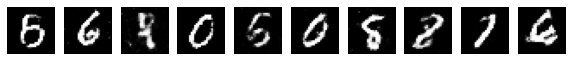

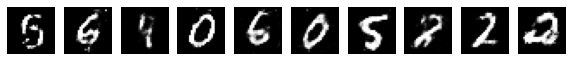

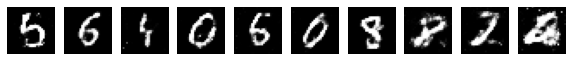

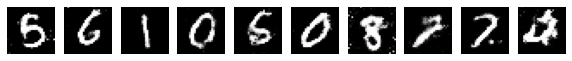

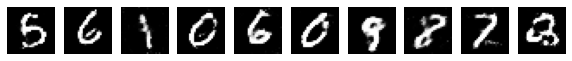

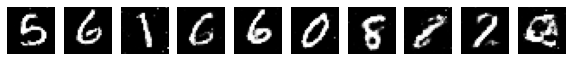

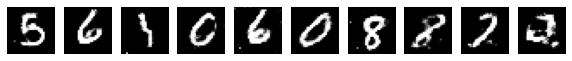

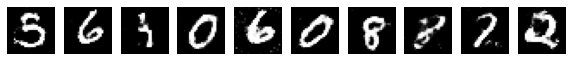

In [33]:
run(config)